# FORESEE - Dark Higgs

### Load Libraries 

In [1]:
import numpy as np
import os
from src.foresee import Foresee, Utility, Model

## 1. Initialization 


All function that we will need are included in the FORESEE package. We start by simply initializing it: 

In [2]:
foresee = Foresee()

The dark Higgs is mainly produced via b-quark decay. To start, let us have a look at the b-quark spectrum in terms of the angle with respect to the beam axis $\theta$ and the momentum $p$. This can be done using the function `get_spectrumplot` which requires the MC particle ID (or simply pid), the MC generator and the energy. The units on the coloraxis are pb/bin. 

FORESEE provides the 2D spectrum as tables for a variety of particles ($\pi^0$, $\eta$, ...), generators (SIBYLL, EPOSLHC, QGSJET, PYTHIA) and collision energies (14, 27 and 100 TeV). The datafiles are stored in the directory `files/hadrons`. 

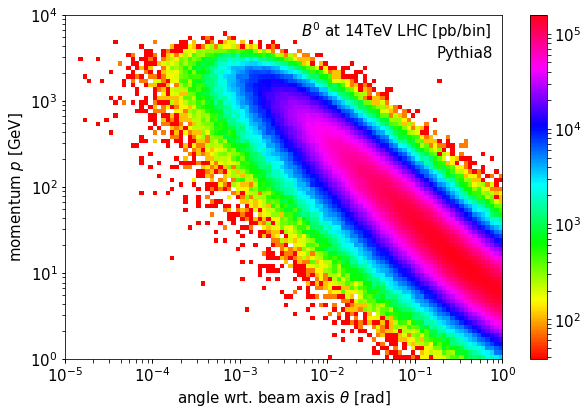

In [3]:
plot=foresee.get_spectrumplot(pid="511", generator="Pythia8", energy="14")
plot.show()

## 2. Specifying the Model: Dark Higgs

The phenomenology of the dark Higgs $\phi$ can be described by the following Lagrangian

\begin{equation}
 \mathcal{L} =  - m_{\phi}^2\ \phi^2  - \sin\theta \ \sum \ (m \ /\ v )\ \bar f \ f  \ \phi - \lambda \ v \ h \phi \phi
\end{equation}

with the dark Higgs mass $m_{\phi}$ and the mixing parameter $\sin\theta$ as free parameters. Additionally, we have the tri-linear coupling $\lambda$ as a thrid parameter of the theory, which we will keep fixed at $\lambda=0.0033$ corresponding to BR$(h \to \phi\phi)=5\%$. For the search for dark Higgs boson at forward experiments we need to know i) the *production rate*, ii) the *lifetime* and iii) possibly the *decay branching fractions* of dark Higgs as function of those two parameters. All properties are specified in the `Model` class. We initialize it with the name of the model as argument. 

In [4]:
energy = "14"
modelname = "DarkHiggs"
model = Model(modelname)

**Production** The Dark Higgs is mainly produced in the flavour changing 2-body decay of $b$-quarks $b \to X_s \phi$. This process includes all b-flavoured hadrons and all strange-flavored decay products. For this we need to specify the total branching fraction into the LLP as function of the `coupling` and the `mass`. 

\begin{equation}
    \text{BR}(b \to X_s\  \phi) = 5.7 \times (1-m_\phi^2/m_b^2)^2 \times \theta^2
\end{equation}

If the tri-linear coupling does not vanish, the dark Higgs can also be produced in 2-body decays of the Higgs boson: $h \to \phi \phi$. The corresponding branching fraction (for our choice of $\lambda=0.0033$) is

\begin{equation}
    \text{BR}(h \to \phi \  \phi) = 4700 \lambda^2 = 0.05
\end{equation}

Here the line `pid1="0"` means that the second decay product is also the LLP of interest. We increase the value of `nsample` to 100, to increase the statistics of the rare decays that lead to a scalar moving into the very forward direction. Since we have two $\phi$ in the final state, we multiply by an additional factor 2. 

In [5]:
model.add_production_2bodydecay(
    pid0 = "5",
    pid1 = "321",
    br = "5.7 * coupling**2 * pow(1.-pow(mass/5.279,2),2)",
    generator = "Pythia8",
    energy = energy,
    nsample = 10,
)

model.add_production_2bodydecay(
    pid0 = "-5",
    pid1 = "321",
    br = "5.7 * coupling**2 * pow(1.-pow(mass/5.279,2),2)",
    generator = "Pythia8",
    energy = energy,
    nsample = 10,
)

model.add_production_2bodydecay(
    pid0 = "25",
    pid1 = "0",
    br = "2*0.05",
    generator = "Pythia8",
    energy = energy,
    nsample = 10,
    scaling = 0,
)

The dark Higgs can alson be produced in 3-body decays $b \to X_s \phi \phi$ via an offshell Higgs boson. This can be added using the function `add_production_3bodydecay()`. It requires to provide `br` which is the differential branching fraction $d\text{BR}/(dq^2 \ d\cos\vartheta)$ where $q^2=(p_{\phi_1}+p_{\phi_2})^2$ and $\vartheta$ is the angle between $p_{\phi_1}$ in the restframe of $p_{\phi_1}+p_{\phi_2}$ and the direction of $p_{\phi_1}+p_{\phi_2}$ in the restframe of the $b$. Since the process is mediated by a an offshell scalar (the Higgs), there is no dependence on the angle $\cos\vartheta$. We can write for the brnching ratio

\begin{equation}
    \frac{d\text{BR} (\phi)}{d q^2 d\cos\vartheta} 
    = \frac{(4.9\cdot 10^{-8} {\rm GeV}^{-2} \ \lambda)^2 m_b^3}{512 \ \pi^3 \  \Gamma_b} 
      \times \left(1-\frac{4 m_\phi^2}{q^2}\right)^{1/2} \!\!\!\!\! \times \left(1-\frac{q^2}{m_b^2}\right)^2
    = 3.68\cdot 10^{-10} \lambda^2  \times \left(1-\frac{4 m_\phi^2}{q^2}\right)^{1/2}  \!\!\!\!\! \times \left(1-\frac{q^2}{m_b^2}\right)^2
\end{equation}

Since we have two $\phi$ in the final state, we multiply by an additional factor 2. 

In [6]:
model.add_production_3bodydecay(
    label= "5_di",
    pid0 = "5",
    pid1 = "321",
    pid2 = "0",
    br = "7.37e-10*np.sqrt(1-4*mass**2/q**2)*(1-q**2/4.5**2)**2",
    generator = "Pythia8",
    energy = energy,
    nsample = 10,
    scaling = 0, 
)

model.add_production_3bodydecay(
    label= "-5_di",
    pid0 = "-5",
    pid1 = "321",
    pid2 = "0",
    br = "7.37e-10*np.sqrt(1-4*mass**2/q**2)*(1-q**2/4.5**2)**2",
    generator = "Pythia8",
    energy = energy,
    nsample = 10,
    scaling = 0, 
)

Particles can also be produced directly in collisions or via mixing with SM particles. However, we will not use this in this example. 

**Lifetime:** For most models the lifetime can be written as $\ c\tau(m,g)\  =\  c\tau(m,g_*) \ \cdot\  g_*^2 \ / \ g^{2}$ where $m$ is the mass, $g$ is the coupling and $g_*$ is some reference coupling. In this case, we can provide a table of masses $m$ and lifetimes $c\tau(m,g_*)$ at a reference coupling $g_*$ using `model.set_ctau_1d`. Alternatively, one can also provide a table of masses $m$, couplings $g$ and lifetimes $c\tau(m,g)$ via `model.set_ctau_2d()`. 

In [7]:
model.set_ctau_1d(
    filename="files/models/"+modelname+"/ctau.txt", 
    coupling_ref=1
)

**Branching Fractions:** For most models, the branching fractions into particular decay channels are independent of the overall couplings. In this case, we can provide a set of tables of masses $m$ and branching fractions $BR(m)$ using `model.set_br_1d`. Alternatively, we can also provide table of masses $m$, couplings $g$ and brnaching fraction $BR(m,g)$ via `model.set_br_2d()`. In both cases, we need to specify a list of decay modes and a list of filenames with the corresponding data tables. 

In [8]:
model.set_br_1d(
    modes=["e_e", "mu_mu"],
    filenames=["files/models/"+modelname+"/br/e_e.txt","files/models/"+modelname+"/br/mu_mu.txt"]
)

## 3. Generate LLP Spectra

After we have specified the model, let us generate the LLP spectra. We first set the model we just created. 

In [9]:
foresee.set_model(model=model)

Let's first look at one benchmark scenario with $m_{\phi}=1.5$ GeV and $\theta=10^{-4}$ using the function `foresee.get_llp_spectrum()`. 

save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_-5_m_1.5.npy
-5 6.18e+01 1.87e-01
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_25_m_1.5.npy
25 2.77e+01 3.72e-04
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_-5_di_m_1.5.npy
-5_di 2.24e-01 1.02e-03
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_5_m_1.5.npy
5 6.18e+01 2.43e-01
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_5_di_m_1.5.npy
5_di 2.23e-01 9.65e-04


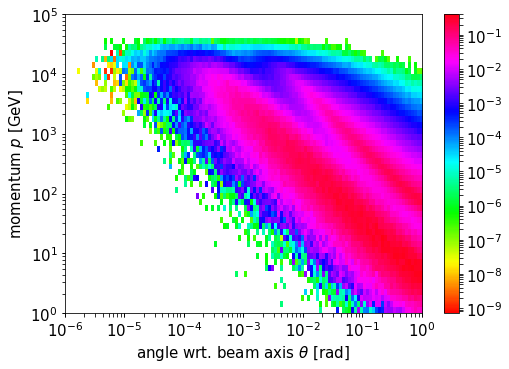

In [10]:
plt = foresee.get_llp_spectrum(mass=1.5, coupling=1e-4, do_plot=True, print_stats=True)
plt.show()

We can now produce a set of LLP spectra for various masses and unit coupling and save them.  

In [11]:
masses = [   
    0.1   ,  0.1122,  0.1259,  0.1413,  0.1585,  0.1778,  0.1995,  
    0.2239,  0.2512,  0.2818,  0.3162,  0.3548,  0.3981,  0.4467,  
    0.5012,  0.5623,  0.6026,  0.631 ,  0.6457,  0.6607,  0.6761,  
    0.6918,  0.7079,  0.7244,  0.7413,  0.7586,  0.7762,  0.7943,  
    0.8128,  0.8318,  0.8511,  0.871 ,  0.8913,  0.912 ,  0.9333,  
    0.955 ,  0.9772,  1.    ,  1.122 ,  1.2589,  1.4125,  1.5   ,
    1.5849,  1.7783,  1.9953,  2.2387,  2.5119,  2.8184,  3.1623,  
    3.5   ,  3.7   ,  3.9811,  5.0119,  6.3096,  7.9433,  10.   ,
    11.22 ,  12.589,  14.125,  15.849,  17.783,  19.953,  22.387,  
    25.119,  28.184,  31.623,  39.811,  50.119,  55.000,  60.000,
    63.096,  79.430,  99.9
]

for mass in masses:
    foresee.get_llp_spectrum(mass=mass,coupling=1)

save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_-5_m_0.1.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_25_m_0.1.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_-5_di_m_0.1.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_5_m_0.1.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_5_di_m_0.1.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_-5_m_0.1122.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_25_m_0.1122.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_-5_di_m_0.1122.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_5_m_0.1122.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_5_di_m_0.1122.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_-5_m_0.1259.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_25_m_0.1259.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_-5_di_m_0.1259.npy
sav

save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_25_m_0.6918.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_-5_di_m_0.6918.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_5_m_0.6918.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_5_di_m_0.6918.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_-5_m_0.7079.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_25_m_0.7079.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_-5_di_m_0.7079.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_5_m_0.7079.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_5_di_m_0.7079.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_-5_m_0.7244.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_25_m_0.7244.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_-5_di_m_0.7244.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_5_m_

save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_-5_di_m_1.5849.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_5_m_1.5849.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_5_di_m_1.5849.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_-5_m_1.7783.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_25_m_1.7783.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_-5_di_m_1.7783.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_5_m_1.7783.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_5_di_m_1.7783.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_-5_m_1.9953.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_25_m_1.9953.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_-5_di_m_1.9953.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_5_m_1.9953.npy
save data to file: files/models/DarkHiggs/LLP_spectra/100TeV_5_di_

## 4. Count Eventrate in Detector

Before counting the number of decays within the detector volume, let us specify the detector geometry. For this we need

- the `distance` from the IP in meter (default: 480)
- the `length` in meter (default: 5)
- the `luminosity` in units of fb^-1 (default: 3000)
- the `selection` depending in `x.x` and `x.y` (default: `np.sqrt(x.x**2 + x.y**2)< 1`)
- the decay `channels` which the detector can see (default: None, meaning all of them)

The default correspond to the FASER2 detector.

In [12]:
distance, selection, length, luminosity, channels = 480, "np.sqrt(x.x**2 + x.y**2)< 1", 5, 3000, None
foresee.set_detector(distance=distance, selection=selection, length=length, luminosity=luminosity, channels=channels)

Let us look for one specific dark photon mass $m_{\phi}=1.5$ GeV at how many particle decay inside the decay volume. This can be done using `get_events()` for which we need to specify again the mass and filename. Additionally, we can specify 

- the `couplings` for which we evaluate the event rate as numpy array (deault `np.logspace(-8,-3,51)`)
- the `preselectioncuts` when reading the LLP spectra in terms of momentum `p` and angle `th` (default: `th<0.01 and p>100`)
- the number `nsample` describing how many randomly choosen values of $\phi_{LLP}$ should sampled (default 1). This is only relevant for detectors that are not cylyndrical or not centered around the beam axis. 
- the production `modes` which should be considered
- the `energy` of the experiments

In [13]:
output = foresee.get_events(mass=1.5, energy=energy, couplings = np.logspace(-8,-3,6))
coups, ctaus, nsigs, energies, weights, _ = output
for coup,ctau,nsig in zip(coups, ctaus, nsigs):
    print "epsilon =", '{:5.3e}'.format(coup), ": nsig =", '{:5.3e}'.format(nsig)

epsilon = 1.000e-08 : nsig = 3.080e+01
epsilon = 1.000e-07 : nsig = 1.219e+03
epsilon = 1.000e-06 : nsig = 1.144e-02
epsilon = 1.000e-05 : nsig = 0.000e+00
epsilon = 1.000e-04 : nsig = 0.000e+00
epsilon = 1.000e-03 : nsig = 0.000e+00


The previous function also outputs the energy distribution of the dark photons which decay inside the detector. Let's have a look at them.

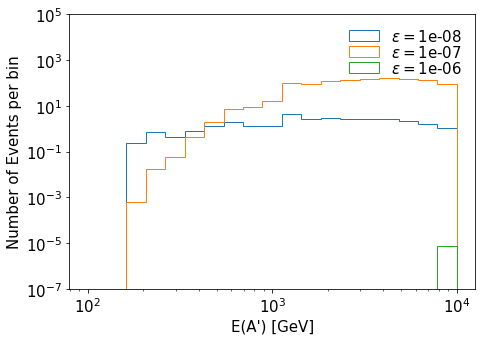

In [14]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(1,1,1)
for coup,en,weight in zip(coups,energies,weights):
    if sum(weight)<10**-5 : continue
    ax.hist(en, weights=weight, bins=np.logspace(2,4, 20), histtype='step', label=r"$\epsilon=$"+str(coup)) 
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(10**-7,10**5) 
    ax.set_xlabel("E(A') [GeV]") 
    ax.set_ylabel("Number of Events per bin") 
    ax.legend(frameon=False, labelspacing=0)
plt.tight_layout()
plt.show()

## 5. Parameter Scan

In the following, we will get the LLP sensitivity reach for different detector configuraions. As an example, we show the FASER2 reach for dark photons for 3 scenarios. We just need to loop over different masses and use the previously introduced funtion `get_events`. The results will be written into a `.npy` file that we can store and plot later.

- the nominal/default setup with $\lambda=0$

In [16]:
#specify setup
if energy == "14": luminosity, distance = 3000 , 480
if energy == "27": luminosity, distance = 15000, 480
if energy == "100": luminosity, distance = 30000, 1000
setup, selection, channels = "default", "np.sqrt(x.x**2 + x.y**2)< 1", None
foresee.set_detector(selection=selection, channels=channels, distance=distance, luminosity=luminosity)

#get reach lambda==0
list_nevents = []    
for mass in masses:
    couplings, _, nevents, _, _ , _ = foresee.get_events(mass=mass, energy=energy, modes=["5","-5"], couplings = np.logspace(-9,-2,71))
    list_nevents.append(nevents)  
        
#save results
np.save("files/models/"+modelname+"/results/"+energy+"TeV_"+setup+".npy",[masses,couplings,list_nevents])

- the nominal/default setup with $\lambda=0.0033$

In [17]:
#specify setup
setup, selection, channels = "trilinear", "np.sqrt(x.x**2 + x.y**2)< 1", None
foresee.set_detector(selection=selection, channels=channels, distance=distance, luminosity=luminosity)

#get reach lambda!=0
list_nevents = []    
for mass in masses:
    couplings, _, nevents, _, _ , _ = foresee.get_events(mass=mass, energy=energy, couplings = np.logspace(-9,-2,71))
    list_nevents.append(nevents)  
        
#save results
np.save("files/models/"+modelname+"/results/"+energy+"TeV_"+setup+".npy",[masses,couplings,list_nevents])

## 6. Plot the Results

Now let's plot the results. We first specify all detector setups for which we want to show result (filename in model/results directory, label, color, linestyle, opacity alpha for filled contours, required number of events).

In [25]:
setups = [ 
    ["14TeV_default.npy",    "BR($H\\to\phi\phi$)=0%"  , "red",         "solid", 0., 3],
    ["14TeV_trilinear.npy",  "BR($H\\to\phi\phi$)=5%"  , "orange",      "solid", 0., 3],
]

Then we specify all the existing bounds (filename in model/bounds directory, label, label position x, label position y, label rotation)

In [26]:
bounds = [ 
    ["bounds_1508.04094.txt", "LHCb $B^0$"  , 0.430, 2.2*10**-3, 90 ],
    ["bounds_1612.08718.txt", "LHCb $B^+$"  , 0.330, 2.2*10**-3, 90 ],
    ["bounds_1612.08718.txt", "LHCb $B^+$"  , 2.500, 2.2*10**-3, 90 ],
    ["bounds_LSND.txt"      , "LSND"        , 0.250, 9.0*10**-5, 90 ],
    ["bounds_CHARM.txt"     , "CHARM"       , 0.250, 4.0*10**-4, 90 ],
    ["bounds_MicroBoone.txt", "$\mu$BooNE"  , 0.138, 3.4*10**-4, 90 ],
    ["bounds_E949.txt"      , "E949"        , 0.102, 1.5*10**-4, 90 ],
    ["bounds_2011.11329.txt", "NA62 $K^+$"  , 0.170, 6.2*10**-4, 90 ],
    ["bounds_2010.07644.txt", "NA62 $\pi^+$", 0.125, 2.4*10**-3, 90 ],
]

We then specify other projected sensitivitities (filename in model/bounds directory, color, label, label position x, label position y, label rotation)

In [27]:
projections = [
    ["limits_SHiP.txt",       "teal",         "SHiP"    , 2.700, 3.2*10**-5, 0  ],
    ["limits_MATHUSLA.txt",   "dodgerblue",   "MATHUSLA", 0.120, 5.0*10**-6, 0  ],
    ["limits_CodexB.txt",     "deepskyblue",  "CodexB"  , 1.700, 2.0*10**-5, 0  ],
    ["limits_LHCb.txt",       "cyan",         "LHCb"    , 3.800, 1.0*10**-4, 0  ],
]

Finally, we can plot everything using `foresee.plot_reach()`. It returns a matplotlib instance, to which we can add further lines and which we can show or save. Below, we add the dark matter relict target line for a specific benchmark.

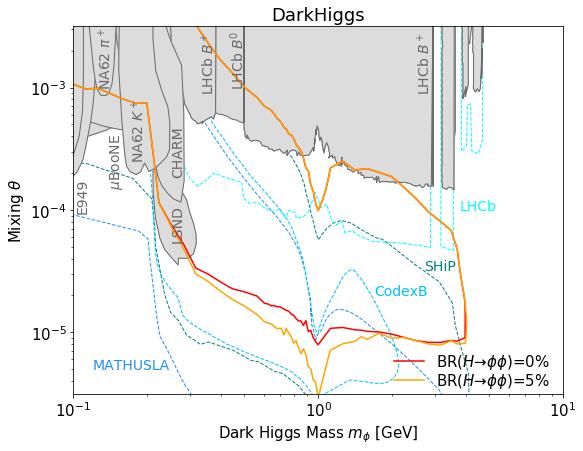

In [28]:
plot = foresee.plot_reach(
    setups=setups,
    bounds=bounds,
    projections=projections,
    title="DarkHiggs", 
    xlims=[0.1,10], 
    ylims=[10**-5.5,10**-2.5],
    xlabel=r"Dark Higgs Mass $m_{\phi}$ [GeV]", 
    ylabel=r"Mixing $\theta$",
    legendloc=(1.00,0.15),
    figsize=(8,6),
)

plot.subplots_adjust(left=0.12, right=0.97, bottom=0.10, top=0.95)
plot.savefig("/Users/felixkling/Downloads/Figure.pdf")
plot.show()